<a href="https://colab.research.google.com/github/TME-6015-2024-FA/test/blob/main/Introduction%20to%20autoencoders%20(AE_VAE_CAE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding AutoEncoders with an example: a step-by-step tutorial
## [Part I](https://medium.com/p/693c3a4e9836) and [Part II](https://medium.com/p/a79d2ea2945e)

## By Daniel Voigt Godoy
### Author of ["Deep Learning with PyTorch Step-by-Step"](https://pytorchstepbystep.com)

### This is the accompanying notebook of my blog post, click on the title above to read it!

In [ ]:
# Unfortunately, reproducibility is not guaranteed across different versions
# If you want to reproduce the outputs, you'll need to use PyTorch LTS version

# !pip3 install torch==1.8.2+cu102 torchvision==0.9.2+cu102 torchaudio==0.8.2 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html

In [ ]:
try:
    import google.colab
    import subprocess
    import os

    if not os.path.exists('src'):
        os.mkdir('src')
        if not os.path.exists('src/autoencoders.py'):
            url = "https://raw.githubusercontent.com/dvgodoy/AccompanyingNotebooks/main/src/autoencoders.py"
            result = subprocess.run(["wget", "--no-cache", "--backups=1", url], stderr=subprocess.PIPE, stdout=subprocess.PIPE)
            print(result.stderr.decode("utf-8"))
            os.rename('autoencoders.py', 'src/autoencoders.py')
    if not os.path.exists('images/autoencoders'):
        os.makedirs('images/autoencoders')
        if not os.path.exists('images/autoencoders/duck_mnist.png'):
            url = "https://raw.githubusercontent.com/dvgodoy/AccompanyingNotebooks/main/images/autoencoders/duck_mnist.png"
            result = subprocess.run(["wget", "--no-cache", "--backups=1", url], stderr=subprocess.PIPE, stdout=subprocess.PIPE)
            print(result.stderr.decode("utf-8"))
            os.rename('duck_mnist.png', 'images/autoencoders/duck_mnist.png')
except ModuleNotFoundError:
    pass

from src.autoencoders import *

--2025-01-01 12:34:56--  https://raw.githubusercontent.com/dvgodoy/AccompanyingNotebooks/main/src/autoencoders.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11666 (11K) [text/plain]
Failed to rename autoencoders.py to autoencoders.py.1: (2) No such file or directory
Saving to: ‘autoencoders.py’

     0K .......... .                                          100% 19.8M=0.001s

2025-01-01 12:34:56 (19.8 MB/s) - ‘autoencoders.py’ saved [11666/11666]


--2025-01-01 12:34:56--  https://raw.githubusercontent.com/dvgodoy/AccompanyingNotebooks/main/images/autoencoders/duck_mnist.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserconte

# Part I - Vanilla AutoEncoders

## An MNIST-like Dataset of Circles

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torch.utils.data import TensorDataset, DataLoader

def draw_circle(radius, center_x=0.5, center_y=0.5, size=28):
    # draw a circle using coordinates for the center, and the radius
    circle = plt.Circle((center_x, center_y), radius, color='k', fill=False)
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.add_patch(circle)
    ax.axis('off')
    buf = fig.canvas.print_to_buffer()
    plt.close()
    # converts matplotlib figure into PIL image, make it grayscale, and resize it
    return np.array(Image.frombuffer('RGBA', buf[1], buf[0]).convert('L').resize((int(size), int(size))))

def gen_circles(n, size=28):
    # generates random coordinates around (0.5, 0.5) as center points
    center_x = np.random.uniform(0.0, 0.03, size=n).reshape(-1, 1)+.5
    center_y = np.random.uniform(0.0, 0.03, size=n).reshape(-1, 1)+.5
    # generates random radius sizes between 0.03 and 0.47
    radius = np.random.uniform(0.03, 0.47, size=n).reshape(-1, 1)
    sizes = np.ones((n, 1))*size

    coords = np.concatenate([radius, center_x, center_y, sizes], axis=1)
    # generates circles using draw_circle function
    circles = np.apply_along_axis(func1d=lambda v: draw_circle(*v), axis=1, arr=coords)
    return circles, radius

np.random.seed(42)
# generates 1,000 circles
circles, radius = gen_circles(1000)

circles_ds = TensorDataset(torch.as_tensor(circles).unsqueeze(1).float()/255, torch.as_tensor(radius))
circles_dl = DataLoader(circles_ds, batch_size=32, shuffle=True, drop_last=True)

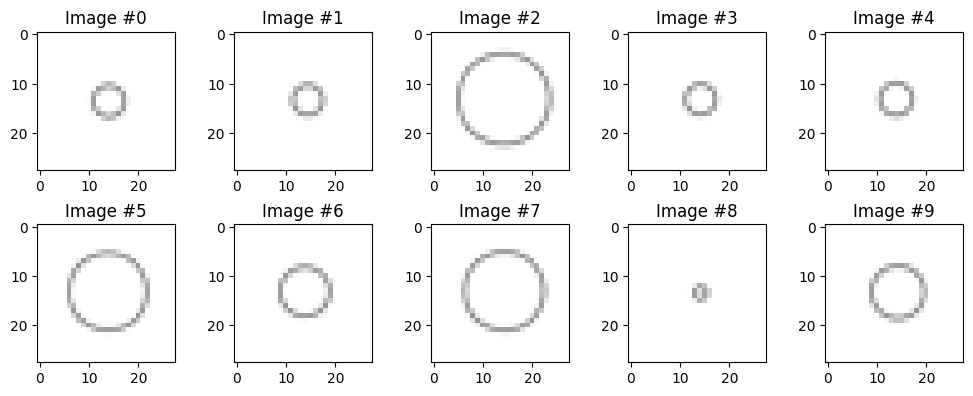

In [ ]:
fig = figure1(circles_ds)

## The Encoder

![encoder](https://github.com/dvgodoy/AccompanyingNotebooks/blob/main/images/autoencoders/encoder_diagram.png?raw=1)

In [ ]:
import torch.nn as nn

def set_seed(self, seed=42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    np.random.seed(seed)

class Encoder(nn.Module):
    def __init__(self, input_shape, z_size, base_model):
        super().__init__()
        self.input_shape = input_shape
        self.z_size = z_size
        self.base_model = base_model

        # appends the "lin_latent" linear layer to map from "output_size"
        # given by the base model to desired size of the representation (z_size)
        output_size = self._get_output_size()
        self.lin_latent = nn.Linear(output_size, z_size)

    def _get_output_size(self):
        # builds a dummy batch containing one dummy tensor
        # full of zeroes with the same shape as the inputs
        device = next(self.base_model.parameters()).device.type
        dummy = torch.zeros(1, *self.input_shape, device=device)
        # sends the dummy batch through the base model to get
        # the output size produced by it
        size = self.base_model(dummy).size(1)
        return size

    def forward(self, x):
        # forwards the input through the base model and then the "lin_latent" layer
        # to get the representation (z)
        base_out = self.base_model(x)
        out = self.lin_latent(base_out)
        return out

set_seed(13)

# we defined our representation (z) as a vector of size one
z_size = 1
# our images are 1@28x28
input_shape = (1, 28, 28) # (C, H, W)

base_model = nn.Sequential(
    # (C, H, W) -> C*H*W
    nn.Flatten(),
    # C*H*W -> 2048
    nn.Linear(np.prod(input_shape), 2048),
    nn.LeakyReLU(),
    # 2048 -> 2048
    nn.Linear(2048, 2048),
    nn.LeakyReLU(),
)

encoder = Encoder(input_shape, z_size, base_model)

In [ ]:
encoder

Encoder(
  (base_model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=2048, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=2048, out_features=2048, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (lin_latent): Linear(in_features=2048, out_features=1, bias=True)
)

In [ ]:
x, _ = circles_ds[7]
z = encoder(x)
z

tensor([[-0.1209]], grad_fn=<AddmmBackward0>)

## Latent Space

![latent space](https://github.com/dvgodoy/AccompanyingNotebooks/blob/main/images/autoencoders/latent_space.png?raw=1)

## The Decoder

![decoder](https://github.com/dvgodoy/AccompanyingNotebooks/blob/main/images/autoencoders/decoder_diagram.png?raw=1)

In [ ]:
decoder = nn.Sequential(
    # z_size -> 2048
    nn.Linear(z_size, 2048),
    nn.LeakyReLU(),
    # 2048 -> 2048
    nn.Linear(2048, 2048),
    nn.LeakyReLU(),
    # 2048 -> C*H*W
    nn.Linear(2048, np.prod(input_shape)),
    # C*H*W -> (C, H, W)
    nn.Unflatten(1, input_shape)
)

In [ ]:
decoder

Sequential(
  (0): Linear(in_features=1, out_features=2048, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=2048, out_features=2048, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=2048, out_features=784, bias=True)
  (5): Unflatten(dim=1, unflattened_size=(1, 28, 28))
)

In [ ]:
x_tilde = decoder(z)
x_tilde, x_tilde.shape

(tensor([[[[ 1.9079e-01, -4.3900e-02, -4.9170e-02,  5.2142e-02, -8.0119e-02,
            -1.6324e-01,  3.8319e-02,  6.2965e-02, -3.7442e-02, -3.6085e-02,
             2.2930e-02, -1.2089e-01,  2.0558e-01,  1.3671e-01,  1.4608e-03,
             1.1066e-02, -1.3429e-01, -3.7842e-02,  6.1736e-02, -3.0216e-02,
            -7.4171e-02, -1.6376e-02, -6.4663e-02, -1.5638e-01, -9.6261e-02,
             5.3312e-02,  6.6354e-02, -2.6915e-02],
           [ 1.8874e-01,  9.7503e-02, -1.3948e-01, -1.2955e-01, -1.2210e-02,
             5.6815e-02, -7.5753e-02,  5.3483e-02,  6.4153e-02, -1.6740e-01,
            -5.0190e-02,  6.2855e-02,  9.7707e-02, -2.2777e-02, -1.1442e-01,
             1.6079e-01, -1.4634e-01,  2.0068e-01, -2.7668e-02,  6.3487e-02,
            -9.6758e-02,  3.0803e-02, -7.0600e-02,  1.1162e-01,  8.6569e-02,
            -1.5205e-02,  1.9754e-01,  1.1691e-01],
           [-7.3312e-02,  9.0082e-02, -4.4267e-02,  1.1471e-01,  6.9005e-02,
             1.5236e-03, -4.2527e-02,  1.4255e-01

## AutoEncoder (AE)

![autoencoder](https://github.com/dvgodoy/AccompanyingNotebooks/blob/main/images/autoencoders/ae_diagram.png?raw=1)

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.enc = encoder
        self.dec = decoder

    def forward(self, x):
        # when encoder met decoder
        enc_out = self.enc(x)
        return self.dec(enc_out)

model_ae = AutoEncoder(encoder, decoder)

In [ ]:
model_ae

AutoEncoder(
  (enc): Encoder(
    (base_model): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=2048, bias=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=2048, out_features=2048, bias=True)
      (4): LeakyReLU(negative_slope=0.01)
    )
    (lin_latent): Linear(in_features=2048, out_features=1, bias=True)
  )
  (dec): Sequential(
    (0): Linear(in_features=1, out_features=2048, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=2048, out_features=784, bias=True)
    (5): Unflatten(dim=1, unflattened_size=(1, 28, 28))
  )
)

![mirror layers](https://github.com/dvgodoy/AccompanyingNotebooks/blob/main/images/autoencoders/enc_dec_mirror.png?raw=1)

### Model Training (AE)

In [ ]:
set_seed(13)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_ae.to(device)
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model_ae.parameters(), 0.0003)

num_epochs = 10

train_losses = []

for epoch in range(1, num_epochs+1):
    batch_losses = []
    for i, (x, _) in enumerate(circles_dl):
        model_ae.train()
        x = x.to(device)

        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model_ae(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, x)
        # Step 3 - Computes gradients
        loss.backward()
        # Step 4 - Updates parameters using gradients and the learning rate
        optim.step()
        optim.zero_grad()

        batch_losses.append(np.array([loss.data.item()]))

    # Average over batches
    train_losses.append(np.array(batch_losses).mean(axis=0))

    print(f'Epoch {epoch:03d} | Loss >> {train_losses[-1][0]:.4f}')

Epoch 001 | Loss >> 0.1388
Epoch 002 | Loss >> 0.0062
Epoch 003 | Loss >> 0.0049
Epoch 004 | Loss >> 0.0048
Epoch 005 | Loss >> 0.0048
Epoch 006 | Loss >> 0.0048
Epoch 007 | Loss >> 0.0048
Epoch 008 | Loss >> 0.0048
Epoch 009 | Loss >> 0.0047
Epoch 010 | Loss >> 0.0046


### Example of Reconstruction

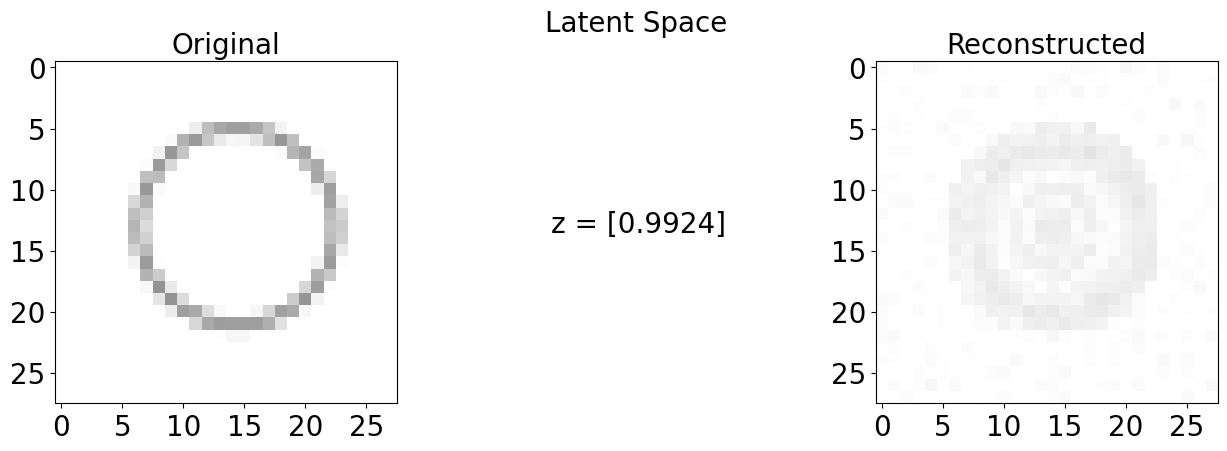

In [ ]:
fig = figure2(model_ae, circles_ds[7][0], device)

### Latent Space Distribution (AE)

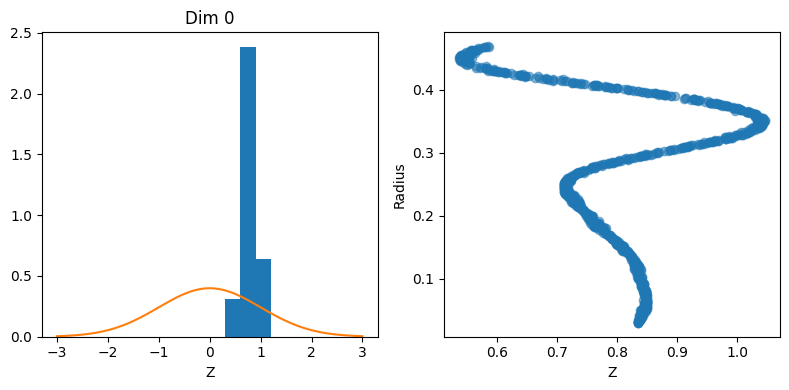

In [ ]:
aeviz1 = AEViz(model_ae.enc, model_ae.dec, circles_dl)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
_ = aeviz1.plot_latent(ax=axs[1])
_ = aeviz1.plot_z_dist(n_cols=1, bins=np.linspace(-3, 3, 21), axs=axs[0])

### Reconstruction (AE)

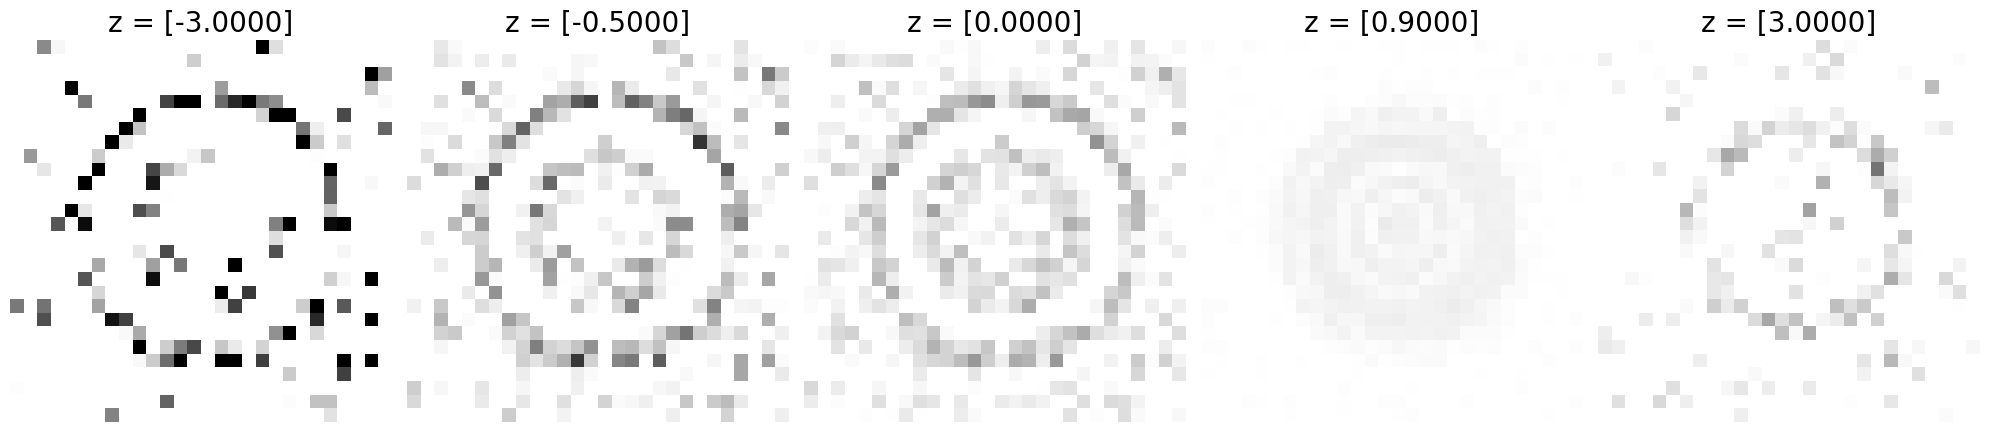

In [ ]:
fig = figure4(model_ae, device)

## AutoEncoder as Anomaly Detectors

![duck mnist](https://github.com/dvgodoy/AccompanyingNotebooks/blob/main/images/autoencoders/duck_mnistified.png?raw=1)

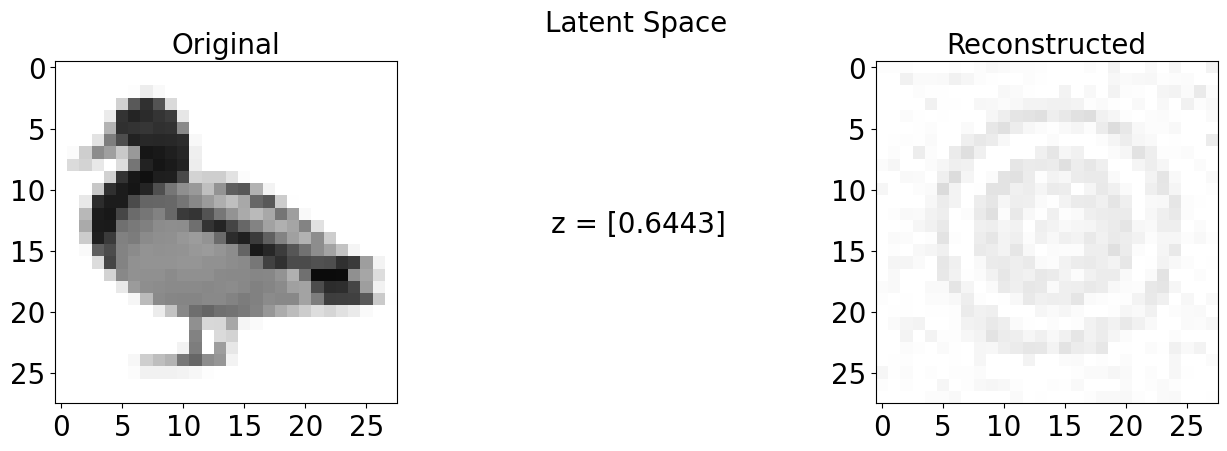

In [ ]:
image_fname = 'images/autoencoders/duck_mnist.png'
fig = figure5(model_ae, image_fname, device)

# Part II - Variational AutoEncoders

## Variational AutoEncoder (VAE)

![vae](https://github.com/dvgodoy/AccompanyingNotebooks/blob/main/images/autoencoders/vae_diagram.png?raw=1)

```EncoderVar(
  (base_model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=2048, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=2048, out_features=2048, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (lin_mu): Linear(in_features=2048, out_features=1, bias=True)
  (lin_var): Linear(in_features=2048, out_features=1, bias=True)
)```

### Reparametrization Trick

In [ ]:
def forward(self, x):
    base_out = self.base_model(x)

    self.mu = self.lin_mu(base_out)
    self.log_var = self.lin_var(base_out)
    std = torch.exp(self.log_var/2)

    eps = torch.randn_like(self.mu)
    z = self.mu + eps * std
    return z

$$
\Large e^{\frac{\log\sigma^2}{2}} = e^{\frac{2\log\sigma}{2}} = e^{\log\sigma} = \sigma
$$

![](https://github.com/dvgodoy/AccompanyingNotebooks/blob/main/images/autoencoders/vae_diagram_reparam.png?raw=1)

In [ ]:
# from torch.distributions.normal.Normal

def sample(self, sample_shape=torch.Size()):
    shape = self._extended_shape(sample_shape)
    with torch.no_grad():
        return torch.normal(self.loc.expand(shape),
                            self.scale.expand(shape))

def rsample(self, sample_shape=torch.Size()):
    shape = self._extended_shape(sample_shape)
    eps = _standard_normal(shape,
                           dtype=self.loc.dtype,
                           device=self.loc.device)
    return self.loc + eps * self.scale

### Kullback-Leibler Divergence/Loss

$$
\Large D_{KL}\left[N(\mu, \sigma) \parallel N(0, 1)\right] = -\frac{1}{2}\left(1 + \log\sigma^2 - \mu^2 - \sigma^2\right)
$$

In [ ]:
def kl_div(mu, std):
    kl_div = -0.5*(1 + np.log(std**2) - mu**2 - std**2)
    return kl_div

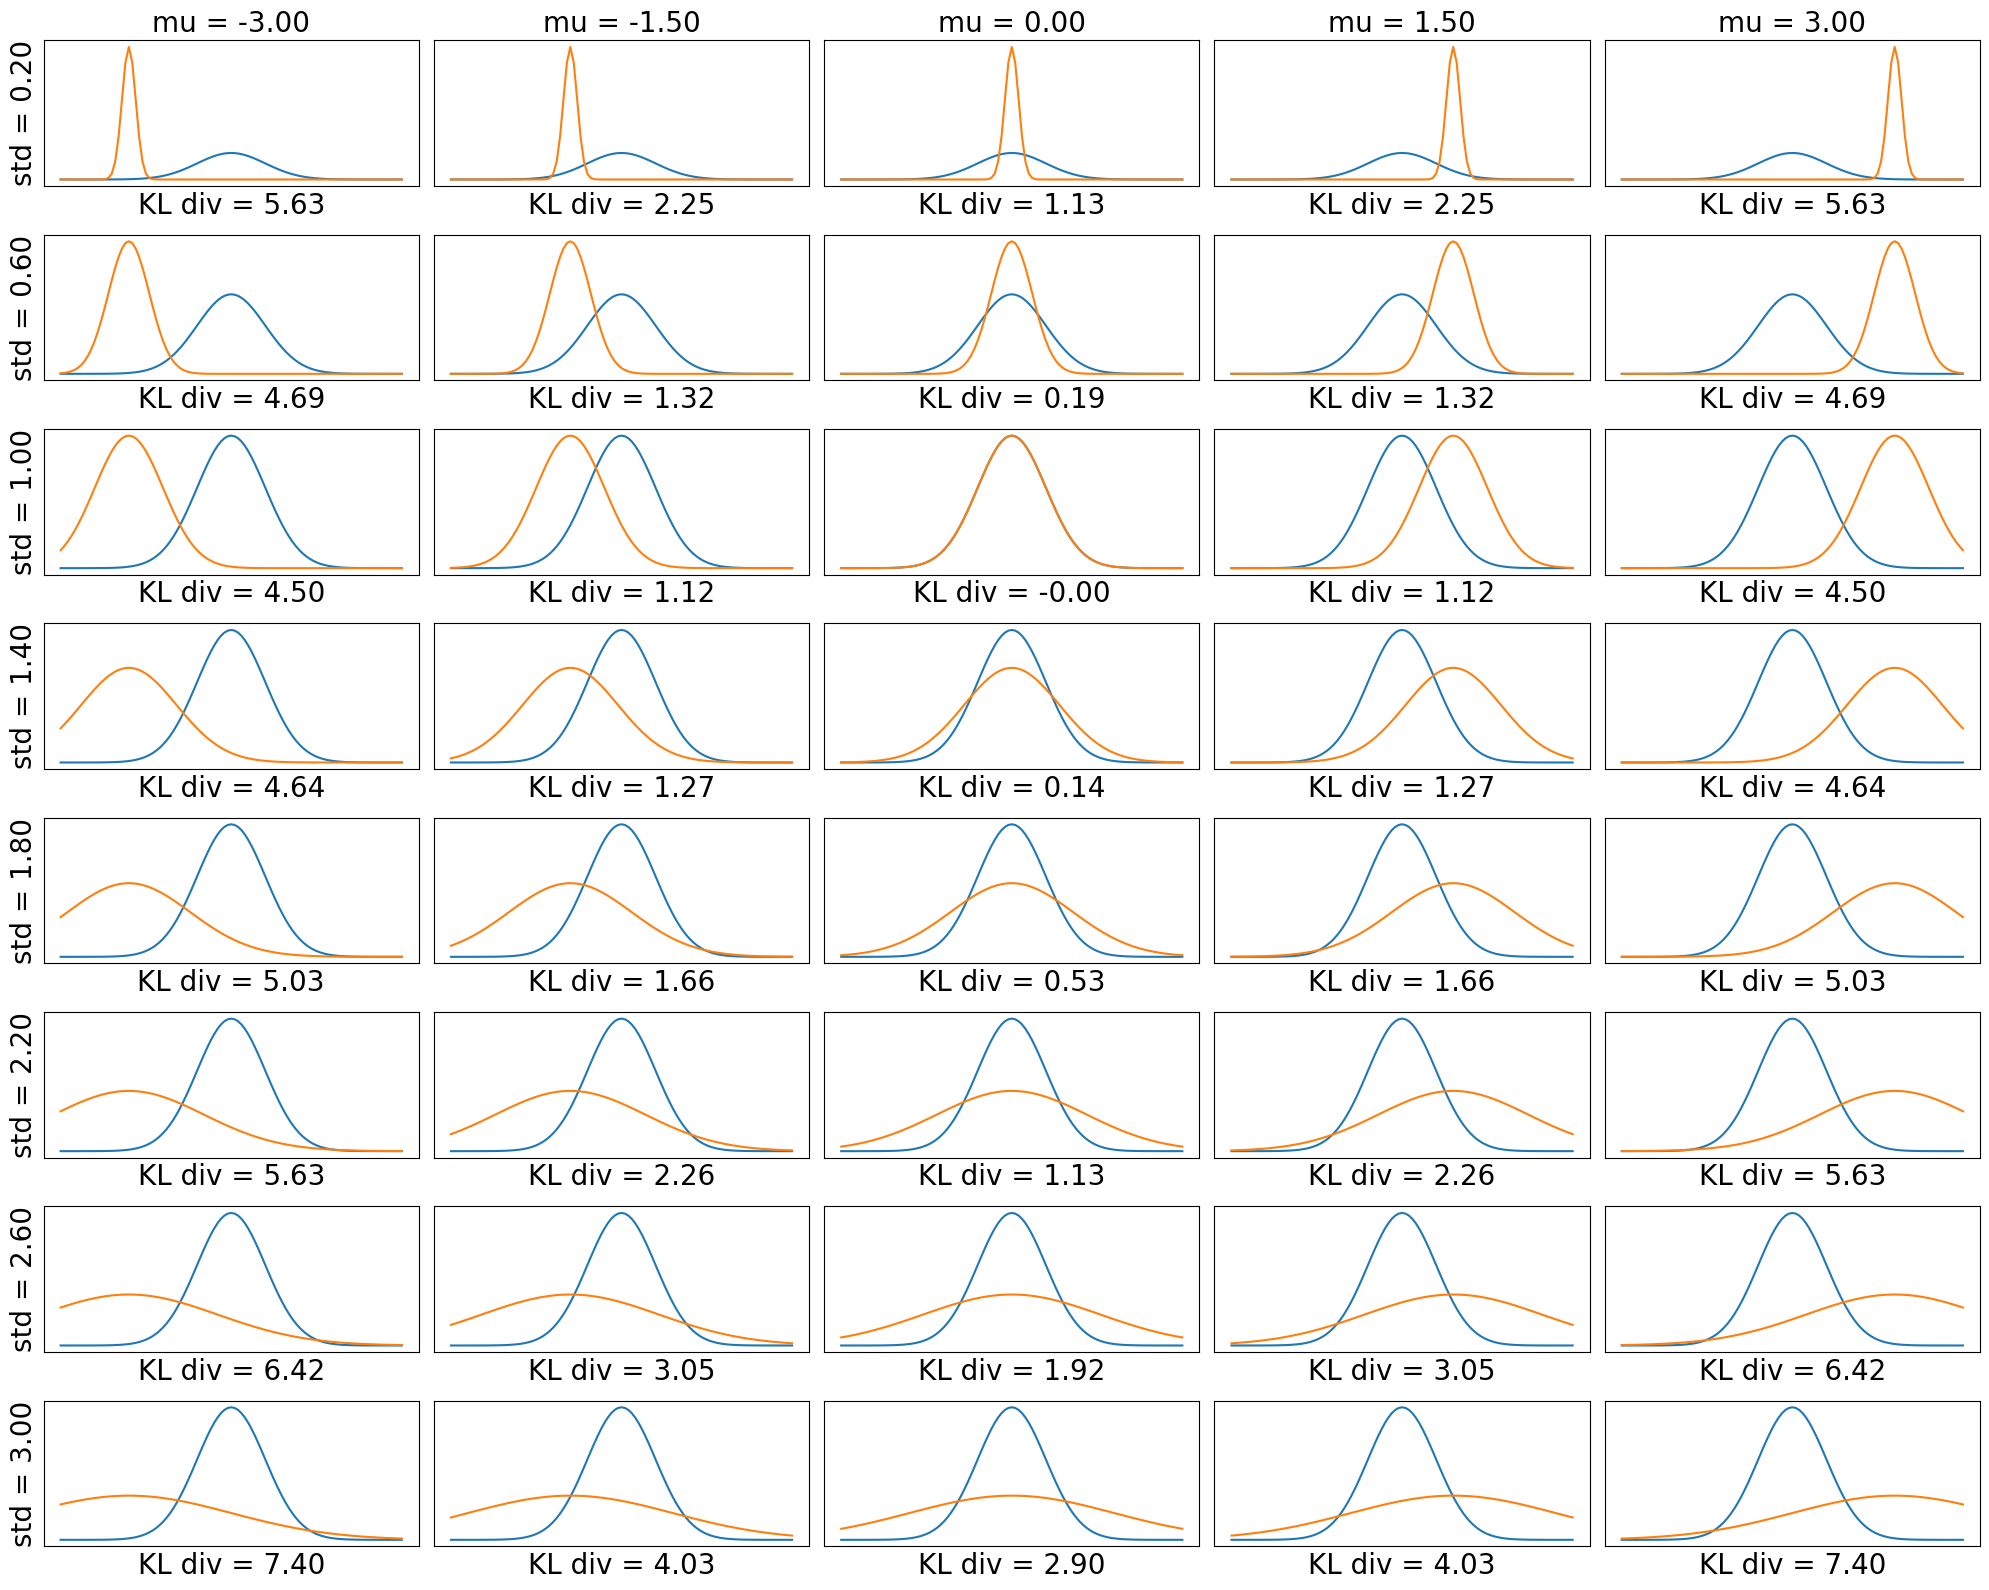

In [ ]:
fig, mus, scales, divergences = figure6()

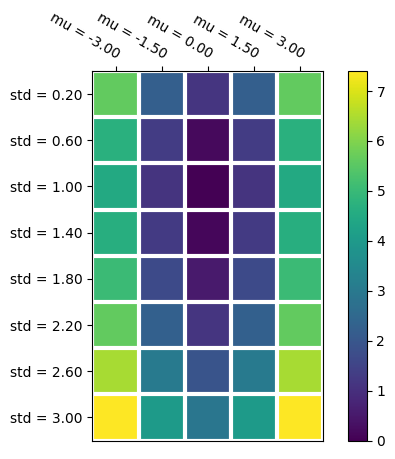

In [ ]:
fig = figure7(mus, scales, divergences)

In [ ]:
class EncoderVar(nn.Module):
    def __init__(self, input_shape, z_size, base_model):
        super().__init__()
        self.z_size = z_size
        self.input_shape = input_shape
        self.base_model = base_model
        output_size = self.get_output_size()
        self.lin_mu = nn.Linear(output_size, z_size)
        self.lin_var = nn.Linear(output_size, z_size)

    def get_output_size(self):
        device = next(self.base_model.parameters()).device.type
        size = self.base_model(torch.zeros(1, *self.input_shape, device=device)).size(1)
        return size

    def kl_loss(self):
        kl_loss = -0.5*(1 + self.log_var - self.mu**2 - torch.exp(self.log_var))
        return kl_loss

    def forward(self, x):
        # the base model, same as the traditional AE
        base_out = self.base_model(x)

        # now the encoder produces means (mu) using the lin_mu output layer
        # and log variances (log_var) using the lin_var output layer
        # we compute the standard deviation (std) from the log variance
        self.mu = self.lin_mu(base_out)
        self.log_var = self.lin_var(base_out)
        std = torch.exp(self.log_var/2)

        # that's the internal random input (epsilon)
        eps = torch.randn_like(self.mu)
        # and that's the z vector
        z = self.mu + eps * std

        return z

In [ ]:
set_seed(13)

base_model = nn.Sequential(
    # (C, H, W) -> C*H*W
    nn.Flatten(),
    # C*H*W -> 2048
    nn.Linear(np.prod(input_shape), 2048),
    nn.LeakyReLU(),
    # 2048 -> 2048
    nn.Linear(2048, 2048),
    nn.LeakyReLU(),
)

encoder_var = EncoderVar(input_shape, z_size, base_model)

decoder_var = nn.Sequential(
    # z_size -> 2048
    nn.Linear(z_size, 2048),
    nn.LeakyReLU(),
    # 2048 -> 2048
    nn.Linear(2048, 2048),
    nn.LeakyReLU(),
    # 2048 -> C*H*W
    nn.Linear(2048, np.prod(input_shape)),
    # C*H*W -> (C, H, W)
    nn.Unflatten(1, input_shape)
)

model_vae = AutoEncoder(encoder_var, decoder_var)

### The Scale of the Losses

In [ ]:
x, y = next(iter(circles_dl))
zs = encoder_var(x)
reconstructed = decoder_var(zs)

In [ ]:
loss_fn_raw = nn.MSELoss(reduction='none')
raw_mse = loss_fn_raw(reconstructed, x)
raw_mse.shape

torch.Size([32, 1, 28, 28])

In [ ]:
raw_mse.sum(), nn.MSELoss(reduction='sum')(reconstructed, x)

(tensor(24377.3906, grad_fn=<SumBackward0>),
 tensor(24377.3906, grad_fn=<MseLossBackward0>))

In [ ]:
sum_over_pixels = raw_mse.sum(dim=[1, 2, 3])
sum_over_pixels.mean()

tensor(761.7935, grad_fn=<MeanBackward0>)

In [ ]:
raw_kl = encoder_var.kl_loss()
raw_kl.shape

torch.Size([32, 1])

In [ ]:
for raw, d in zip([raw_mse, raw_kl], [[1, 2, 3], 1]):
    print(f'{raw.mean(dim=d).mean(dim=0).item():.4f}, {raw.mean(dim=d).sum(dim=0).item():.4f}, '
          f'{raw.sum(dim=d).mean(dim=0).item():.4f}, {raw.sum(dim=d).sum(dim=0).item():.4f}')

0.9717, 31.0936, 761.7935, 24377.3926
0.0062, 0.1998, 0.0062, 0.1998


### Model Training (VAE)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_vae.to(device)
loss_fn = nn.MSELoss(reduction='none')
optim = torch.optim.Adam(model_vae.parameters(), 0.0003)

num_epochs = 30

train_losses = []

reconstruction_loss_factor = 1

for epoch in range(1, num_epochs+1):
    batch_losses = []
    for i, (x, _) in enumerate(circles_dl):
        model_vae.train()
        x = x.to(device)

        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model_vae(x)

        # Step 2 - Computes the loss
        # reduce (sum) over pixels (dim=[1, 2, 3])
        # and then reduce (sum) over batch (dim=0)
        loss = loss_fn(yhat, x).sum(dim=[1, 2, 3]).sum(dim=0)
        # reduce (sum) over z (dim=1)
        # and then reduce (sum) over batch (dim=0)
        kl_loss = model_vae.enc.kl_loss().sum(dim=1).sum(dim=0)
        # we're adding the KL loss to the original MSE loss
        total_loss = reconstruction_loss_factor * loss + kl_loss

        # Step 3 - Computes gradients
        total_loss.backward()
        # Step 4 - Updates parameters using gradients and the learning rate
        optim.step()
        optim.zero_grad()

        batch_losses.append(np.array([total_loss.data.item(), loss.data.item(), kl_loss.data.item()]))

    # Average over batches
    train_losses.append(np.array(batch_losses).mean(axis=0))

    print(f'Epoch {epoch:03d} | Loss >> {train_losses[-1][0]:.4f}/{train_losses[-1][1]:.4f}/{train_losses[-1][2]:.4f}')

Epoch 001 | Loss >> 2091.0371/2026.1959/64.8412
Epoch 002 | Loss >> 179.1810/142.0506/37.1304
Epoch 003 | Loss >> 149.7852/130.4884/19.2967
Epoch 004 | Loss >> 138.5444/128.4482/10.0961
Epoch 005 | Loss >> 132.8374/127.2825/5.5549
Epoch 006 | Loss >> 136.0654/132.2842/3.7812
Epoch 007 | Loss >> 130.6923/128.5275/2.1648
Epoch 008 | Loss >> 128.8194/126.5572/2.2622
Epoch 009 | Loss >> 130.9050/129.5054/1.3996
Epoch 010 | Loss >> 138.4076/135.5679/2.8397
Epoch 011 | Loss >> 140.0841/137.0091/3.0750
Epoch 012 | Loss >> 130.0178/128.9690/1.0488
Epoch 013 | Loss >> 132.2212/131.0809/1.1403
Epoch 014 | Loss >> 130.7487/129.5140/1.2347
Epoch 015 | Loss >> 130.5474/129.8967/0.6508
Epoch 016 | Loss >> 130.3198/129.4005/0.9194
Epoch 017 | Loss >> 132.1007/131.2257/0.8750
Epoch 018 | Loss >> 128.6962/127.9792/0.7170
Epoch 019 | Loss >> 130.0372/129.7502/0.2870
Epoch 020 | Loss >> 129.4999/129.0837/0.4162
Epoch 021 | Loss >> 133.2873/131.8493/1.4381
Epoch 022 | Loss >> 128.5595/128.1131/0.4464
Epoc

### Latent Space Distribution (VAE)

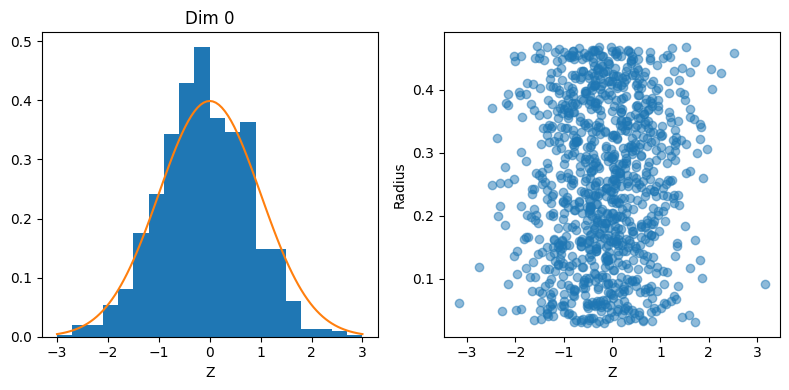

In [ ]:
aeviz2 = AEViz(model_vae.enc, model_vae.dec, circles_dl)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
_ = aeviz2.plot_latent(ax=axs[1])
_ = aeviz2.plot_z_dist(n_cols=1, bins=np.linspace(-3, 3, 21), axs=axs[0])

### Reconstruction (VAE)

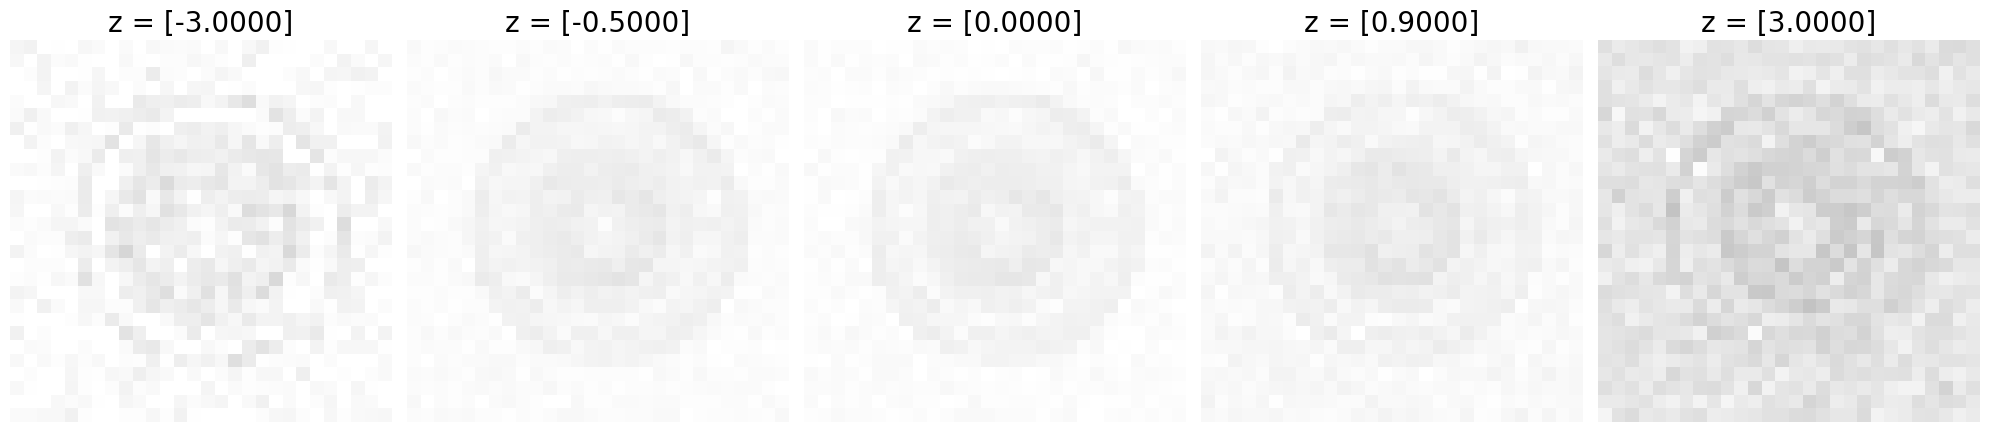

In [ ]:
fig = figure4(model_vae, device)

## Convolutional Variational AutoeEncoder (CVAE)

In [ ]:
set_seed(13)

z_size = 1
n_filters = 32
in_channels = 1
img_size = 28
input_shape = (in_channels, img_size, img_size)

base_model = nn.Sequential(
    # in_channels@28x28 -> n_filters@28x28
    nn.Conv2d(in_channels, n_filters, kernel_size=3, stride=1, padding=1),
    nn.LeakyReLU(),

    # n_filters@28x28 -> (n_filters*2)@14x14
    nn.Conv2d(n_filters, n_filters*2, kernel_size=3, stride=2, padding=1),
    nn.LeakyReLU(),

    # (n_filters*2)@14x14 -> (n_filters*2)@7x7
    nn.Conv2d(n_filters*2, n_filters*2, kernel_size=3, stride=2, padding=1),
    nn.LeakyReLU(),

    # (n_filters*2)@7x7 -> (n_filters*2)@7x7
    nn.Conv2d(n_filters*2, n_filters*2, kernel_size=3, stride=1, padding=1),
    nn.LeakyReLU(),

    # (n_filters*2)@7x7 -> (n_filters*2)*7*7
    nn.Flatten(),
)

encoder_var_cnn = EncoderVar(input_shape, z_size, base_model)

In [ ]:
encoder_var_cnn

EncoderVar(
  (base_model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (lin_mu): Linear(in_features=3136, out_features=1, bias=True)
  (lin_var): Linear(in_features=3136, out_features=1, bias=True)
)

In [ ]:
decoder_cnn = nn.Sequential(
    # z_size -> (n_filters*2)*7*7
    nn.Linear(z_size, (n_filters*2)*int(img_size/4)**2),

    # (n_filters*2)*7*7 -> (n_filters*2)@7x7
    nn.Unflatten(1, (n_filters*2, int(img_size/4), int(img_size/4))),

    # (n_filters*2)@7x7 -> (n_filters*2)@7x7
    nn.ConvTranspose2d(n_filters*2, n_filters*2, kernel_size=3, stride=1, padding=1, output_padding=0),
    nn.LeakyReLU(),

    # (n_filters*2)@7x7 -> (n_filters*2)@14x14
    nn.ConvTranspose2d(n_filters*2, n_filters*2, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.LeakyReLU(),

    # (n_filters*2)@15x15 -> n_filters@28x28
    nn.ConvTranspose2d(n_filters*2, n_filters, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.LeakyReLU(),

    # n_filters@28x28 -> in_channels@28x28
    nn.ConvTranspose2d(n_filters, in_channels, kernel_size=3, stride=1, padding=1, output_padding=0),
    nn.Sigmoid(),
)

### Model Training (CVAE)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_vae_cnn = AutoEncoder(encoder_var_cnn, decoder_cnn)
model_vae_cnn.to(device)
loss_fn = nn.MSELoss(reduction='none')
optim = torch.optim.Adam(model_vae_cnn.parameters(), 0.0003)

num_epochs = 30

train_losses = []

reconstruction_loss_factor = 1

for epoch in range(1, num_epochs+1):
    batch_losses = []
    for i, (x, _) in enumerate(circles_dl):
        model_vae_cnn.train()
        x = x.to(device)

        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model_vae_cnn(x)

        # Step 2 - Computes the loss
        loss = loss_fn(yhat, x).sum(dim=[1, 2, 3]).sum(dim=0)
        kl_loss = model_vae_cnn.enc.kl_loss().sum(dim=1).sum(dim=0)
        total_loss = reconstruction_loss_factor * loss + kl_loss

        # Step 3 - Computes gradients
        total_loss.backward()

        # Step 4 - Updates parameters using gradients and the learning rate
        optim.step()
        optim.zero_grad()

        batch_losses.append(np.array([total_loss.data.item(), loss.data.item(), kl_loss.data.item()]))

    # Average over batches
    train_losses.append(np.array(batch_losses).mean(axis=0))

    print(f'Epoch {epoch:03d} | Loss >> {train_losses[-1][0]:.4f}/{train_losses[-1][1]:.4f}/{train_losses[-1][2]:.4f}')

Epoch 001 | Loss >> 1976.3914/1899.0641/77.3273
Epoch 002 | Loss >> 169.3562/164.8163/4.5399
Epoch 003 | Loss >> 140.4270/140.4087/0.0183
Epoch 004 | Loss >> 137.3398/137.3352/0.0046
Epoch 005 | Loss >> 135.7565/135.7246/0.0319
Epoch 006 | Loss >> 134.1208/134.0239/0.0969
Epoch 007 | Loss >> 131.6049/131.4377/0.1672
Epoch 008 | Loss >> 129.6338/129.4575/0.1763
Epoch 009 | Loss >> 127.4230/127.2493/0.1737
Epoch 010 | Loss >> 126.8995/126.6936/0.2059
Epoch 011 | Loss >> 125.8358/125.6446/0.1911
Epoch 012 | Loss >> 124.3699/124.2362/0.1338
Epoch 013 | Loss >> 123.5457/123.4360/0.1097
Epoch 014 | Loss >> 123.2500/123.1819/0.0681
Epoch 015 | Loss >> 122.3855/122.3433/0.0423
Epoch 016 | Loss >> 122.4233/122.3552/0.0681
Epoch 017 | Loss >> 122.2109/122.1716/0.0393
Epoch 018 | Loss >> 121.8363/121.8122/0.0241
Epoch 019 | Loss >> 121.0805/121.0562/0.0243
Epoch 020 | Loss >> 120.7818/120.7671/0.0147
Epoch 021 | Loss >> 120.9964/120.9799/0.0165
Epoch 022 | Loss >> 120.7091/120.6852/0.0239
Epoch 0

### Latent Space Distribution (CVAE)

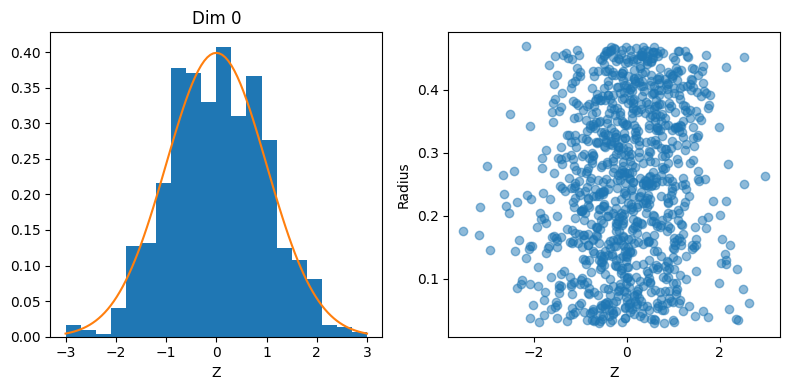

In [ ]:
aeviz3 = AEViz(model_vae_cnn.enc, model_vae_cnn.dec, circles_dl)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
_ = aeviz3.plot_latent(ax=axs[1])
_ = aeviz3.plot_z_dist(n_cols=1, bins=np.linspace(-3, 3, 21), axs=axs[0])

### Reconstruction (CVAE)

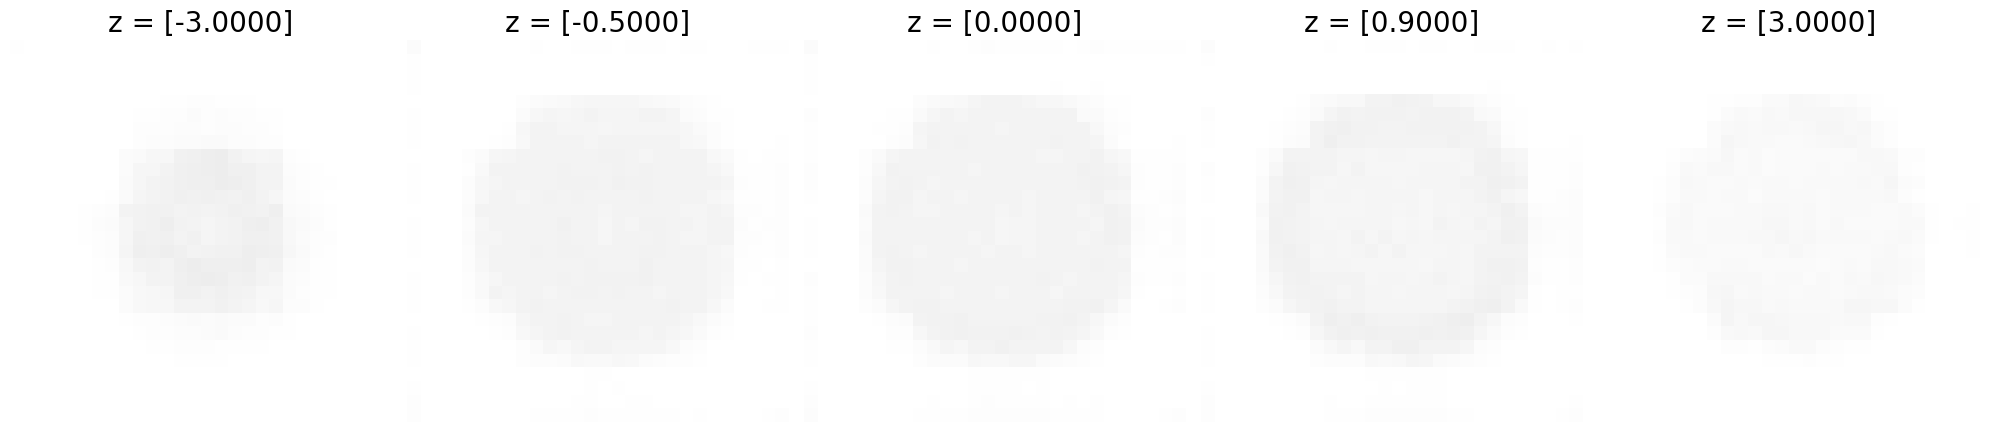

In [ ]:
fig = figure4(model_vae_cnn, device)

## Further Reading

If you want to learn more about PyTorch, Computer Vision, and NLP, give my own series of books, "Deep Learning with PyTorch Step-by-Step", a try :-)

[![](https://github.com/dvgodoy/PyTorchStepByStep/raw/master/images/new_books.png)](https://pytorchstepbystep.com/)

# Bonus: [Transposed Convolutions](https://towardsdatascience.com/what-are-transposed-convolutions-2d43ac1a0771)

![convolution](https://github.com/dvgodoy/AccompanyingNotebooks/blob/main/images/autoencoders/conv8.png?raw=1)

In [ ]:
input_image = torch.ones((1, 1, 2, 2)) # N, C, H, W
input_image

tensor([[[[1., 1.],
          [1., 1.]]]])

In [ ]:
kernel_size = 2
kernel = torch.ones((1, 1, kernel_size, kernel_size))
kernel

tensor([[[[1., 1.],
          [1., 1.]]]])

In [ ]:
import torch.nn.functional as F

stride_transp = 1
padding_transp = 0

F.conv_transpose2d(input_image,
                   weight=kernel,
                   stride=stride_transp,
                   padding=padding_transp)

tensor([[[[1., 2., 1.],
          [2., 4., 2.],
          [1., 2., 1.]]]])

In [ ]:
padding_implicit = kernel_size - padding_transp - 1
padded_image = F.pad(input_image, pad=[padding_implicit]*4)
padded_image

tensor([[[[0., 0., 0., 0.],
          [0., 1., 1., 0.],
          [0., 1., 1., 0.],
          [0., 0., 0., 0.]]]])

In [ ]:
F.conv2d(padded_image, weight=kernel, stride=1)

tensor([[[[1., 2., 1.],
          [2., 4., 2.],
          [1., 2., 1.]]]])

![transposed convolution](https://github.com/dvgodoy/AccompanyingNotebooks/blob/main/images/autoencoders/conv_transp_s1.png?raw=1)

In [ ]:
stride_transp = 2
padding_transp = 0

F.conv_transpose2d(input_image,
                   weight=kernel,
                   stride=stride_transp,
                   padding=padding_transp)

tensor([[[[1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.]]]])

In [ ]:
zero_added_image = torch.tensor([[[[1, 0, 1],
                                   [0, 0, 0],
                                   [1, 0, 1]]]]).float()

In [ ]:
padding_implicit = kernel_size - padding_transp - 1
stride = 1

F.conv2d(zero_added_image,
         weight=kernel,
         stride=1,
         padding=padding_implicit)

tensor([[[[1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.]]]])

![transposed convolution](https://github.com/dvgodoy/AccompanyingNotebooks/blob/main/images/autoencoders/conv_transp_s2.png?raw=1)

$$
\Large \text{stride}^T \times (\text{image_size}-1) + \text{kernel_size} - 2 \times \text{padding}^T
$$